In [1]:
# CELL 1: Install dependencies
import sys, subprocess
pkgs = ["geopandas", "shapely", "requests", "ipywidgets", "numpy", "xarray", "netCDF4", "scipy"]
subprocess.check_call([sys.executable, "-m", "pip", "install"] + pkgs + ["--quiet"])
print("Done!")

Done!


In [2]:
# CELL 2: Imports and configuration
import os
import zipfile
import requests
import numpy as np
import geopandas as gpd
import xarray as xr
import ipywidgets as widgets
from shapely.geometry import box, Point
from shapely.ops import unary_union, nearest_points, linemerge
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path
from IPython.display import display, clear_output, HTML

# Blue Habitats - Harris et al. (2014) Global Seafloor Geomorphic Features Map
# Licensed under Creative Commons Attribution 4.0 International License

DROPBOX_URL = "https://www.dropbox.com/scl/fi/mm01uhaa0ohyfitckmru7/global-seafloor-geomorphic-features-map.zip?rlkey=so36tzk2mfq6344xioq4v92y0&dl=1"

FEATURES = [
    "shelf", "slope", "rise", "abyss", "basin", "canyon", "escarpment", "fan",
    "glacial_trough", "guyot", "hadal", "plateau", "ridge", "rift_valley",
    "seamount", "sill", "spreading_ridge", "terrace", "trench", "trough", "bridge"
]

print("Harris et al. (2014) - Global Seafloor Geomorphic Features")
print("With Shelf Break Distance Raster Generation")
print("=" * 50)

Harris et al. (2014) - Global Seafloor Geomorphic Features
With Shelf Break Distance Raster Generation


In [3]:
# CELL 3: Interface

# ============================================================
# DOWNLOAD AND EXTRACTION FUNCTIONS
# ============================================================

def download_and_extract(url, dest_folder, progress=None):
    """Download and extract the Harris et al. dataset."""
    dest = Path(dest_folder)
    zip_path = dest / "harris_geomorphology.zip"
    extract_path = dest / "harris_geomorphology"
    
    if extract_path.exists() and any(extract_path.glob("*.shp")):
        print(f"Data already exists in {extract_path}")
        return extract_path
    
    dest.mkdir(parents=True, exist_ok=True)
    extract_path.mkdir(parents=True, exist_ok=True)
    
    print(f"Downloading dataset (~389 MB)...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    if progress:
        progress.max = 100
        progress.value = 0
        progress.description = "Download:"
    
    downloaded = 0
    last_percent = 0
    
    with open(zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    current_percent = int((downloaded / total_size) * 100)
                    if current_percent > last_percent:
                        last_percent = current_percent
                        if progress:
                            progress.value = current_percent
    
    if progress:
        progress.value = 100
    print(f"Download complete: {downloaded / 1e6:.1f} MB")
    
    print("Extracting files...")
    if progress:
        progress.description = "Extract:"
        progress.value = 0
    
    with zipfile.ZipFile(zip_path, 'r') as zf:
        members = zf.namelist()
        for i, member in enumerate(members):
            zf.extract(member, extract_path)
            if progress and i % 10 == 0:
                progress.value = int((i / len(members)) * 100)
    
    if progress:
        progress.value = 100
    
    zip_path.unlink()
    print(f"Extracted to {extract_path}")
    return extract_path


def find_shapefile(data_path, feature_name):
    """Find shapefile for a given feature."""
    data_path = Path(data_path)
    patterns = [f"*{feature_name}*.shp", f"*{feature_name.replace('_', '')}*.shp"]
    for pattern in patterns:
        matches = list(data_path.rglob(pattern))
        if matches:
            return matches[0]
    return None


def list_available_shapefiles(data_path):
    """List all available shapefiles."""
    return {shp.stem: shp for shp in Path(data_path).rglob("*.shp")}


def clip_to_bbox(gdf, bbox):
    """Clip GeoDataFrame to bounding box."""
    minlon, minlat, maxlon, maxlat = bbox
    return gdf.clip(box(minlon, minlat, maxlon, maxlat))


def process_features(data_path, features, bbox, outdir, prog=None):
    """Process selected vector features."""
    data_path = Path(data_path)
    outpath = Path(outdir)
    outpath.mkdir(parents=True, exist_ok=True)
    
    available = list_available_shapefiles(data_path)
    print(f"Found {len(available)} shapefiles in dataset")
    
    if prog:
        prog.max = 100
        prog.value = 0
        prog.description = "Process:"
    
    results = []
    
    for i, feature in enumerate(features):
        shp_path = find_shapefile(data_path, feature)
        if not shp_path:
            for name, path in available.items():
                if feature.lower() in name.lower():
                    shp_path = path
                    break
        
        if not shp_path:
            print(f"  SKIP {feature}: not found")
            continue
        
        try:
            print(f"  Processing {feature}...")
            gdf = gpd.read_file(shp_path)
            gdf_clipped = clip_to_bbox(gdf, bbox) if bbox else gdf
            
            if gdf_clipped.empty:
                print(f"    No features in area")
                continue
            
            out_file = outpath / f"harris_{feature}.shp"
            gdf_clipped.to_file(out_file)
            print(f"    OK: {len(gdf_clipped)} features -> {out_file.name}")
            results.append((feature, len(gdf_clipped), out_file))
        except Exception as e:
            print(f"    FAIL: {str(e)[:60]}")
        
        if prog:
            prog.value = int(((i + 1) / len(features)) * 100)
    
    return results


# ============================================================
# SHELF BREAK DISTANCE RASTER FUNCTIONS
# ============================================================

def extract_shelf_break_line(shelf_gdf, slope_gdf):
    """Extract shelf break line from shelf/slope boundary."""
    if shelf_gdf.empty or slope_gdf.empty:
        return None, None, None
    
    shelf_union = unary_union(shelf_gdf.geometry)
    slope_union = unary_union(slope_gdf.geometry)
    
    # Try to find shared boundary
    shelf_break = shelf_union.boundary.intersection(slope_union.boundary)
    
    if shelf_break.is_empty:
        shelf_break = shelf_union.boundary.intersection(slope_union)
    
    if shelf_break.is_empty:
        print("  Warning: Using outer shelf boundary as approximation")
        shelf_break = shelf_union.boundary
    
    try:
        shelf_break = linemerge(shelf_break)
    except:
        pass
    
    return shelf_break, shelf_union, slope_union


def haversine_km(lat1, lon1, lat2, lon2):
    """Calculate distance in km using Haversine formula."""
    R = 6371.0
    lat1_rad, lat2_rad = np.radians(lat1), np.radians(lat2)
    dlat, dlon = np.radians(lat2 - lat1), np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


def create_distance_raster(shelf_break_line, shelf_union, bbox, resolution, max_dist_km=500, prog=None):
    """Create signed distance raster to shelf break."""
    lon_min, lat_min, lon_max, lat_max = bbox
    
    lons = np.arange(lon_min, lon_max + resolution, resolution)
    lats = np.arange(lat_min, lat_max + resolution, resolution)
    
    print(f"  Grid: {len(lats)} x {len(lons)} = {len(lats) * len(lons)} points")
    
    distance_km = np.full((len(lats), len(lons)), np.nan)
    
    if prog:
        prog.max = len(lats)
        prog.value = 0
        prog.description = "Raster:"
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            point = Point(lon, lat)
            
            try:
                nearest_geom = nearest_points(point, shelf_break_line)[1]
                dist_km = haversine_km(lat, lon, nearest_geom.y, nearest_geom.x)
                
                # Sign: negative if on shelf, positive if in deep ocean
                if shelf_union.contains(point):
                    dist_km = -dist_km
                
                distance_km[i, j] = np.clip(dist_km, -max_dist_km, max_dist_km)
            except:
                pass
        
        if prog:
            prog.value = i + 1
    
    return lats, lons, distance_km


def save_distance_netcdf(lats, lons, distance_km, output_path, bbox, resolution):
    """Save distance raster as NetCDF."""
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    ds = xr.Dataset(
        {
            'shelf_break_distance': (['latitude', 'longitude'], distance_km, {
                'units': 'km',
                'long_name': 'Signed distance to shelf break',
                'description': 'Negative=shelf_side, Positive=deep_ocean_side, Zero=on_shelf_break',
                'source': 'Harris et al. (2014) Marine Geology 352: 4-24',
            })
        },
        coords={
            'latitude': ('latitude', lats, {'units': 'degrees_north'}),
            'longitude': ('longitude', lons, {'units': 'degrees_east'}),
        },
        attrs={
            'title': 'Signed Distance to Continental Shelf Break',
            'source': 'Harris et al. (2014) Global Seafloor Geomorphic Features Map',
            'resolution_degrees': resolution,
            'bbox': str(bbox),
        }
    )
    
    nc_file = output_path / "shelf_break_distance.nc"
    ds.to_netcdf(nc_file)
    return nc_file


# ============================================================
# FOLDER BROWSER CLASS
# ============================================================

class FolderBrowser:
    def __init__(self, start='.', label="Folder"):
        self.cur = Path(start).resolve()
        self.sel = self.cur
        self.label = label
        self.html = widgets.HTML(f"<code>{self.cur}</code>")
        self.dd = widgets.Select(options=self._list(), layout=widgets.Layout(width='100%', height='80px'))
        self.b_up = widgets.Button(description='Up', layout=widgets.Layout(width='50px'))
        self.b_in = widgets.Button(description='Enter', layout=widgets.Layout(width='60px'))
        self.b_sel = widgets.Button(description='Select', button_style='success', layout=widgets.Layout(width='60px'))
        self.txt = widgets.Text(placeholder='new folder', layout=widgets.Layout(width='100px'))
        self.b_new = widgets.Button(description='+', layout=widgets.Layout(width='35px'))
        self.selhtml = widgets.HTML(f"<b>Selected:</b> <code>{self.sel}</code>")
        self.b_up.on_click(lambda b: self._up())
        self.b_in.on_click(lambda b: self._enter())
        self.b_sel.on_click(lambda b: self._select())
        self.b_new.on_click(lambda b: self._create())
        self.w = widgets.VBox([
            widgets.HTML(f"<b>{label}</b>"), self.html, self.dd,
            widgets.HBox([self.b_up, self.b_in, self.b_sel, self.txt, self.b_new]),
            self.selhtml
        ])
    
    def _list(self):
        try:
            return ['.'] + [x.name for x in sorted(self.cur.iterdir()) if x.is_dir() and not x.name.startswith('.')]
        except:
            return ['.']
    
    def _refresh(self):
        self.html.value = f"<code>{self.cur}</code>"
        self.dd.options = self._list()
    
    def _up(self):
        if self.cur.parent != self.cur:
            self.cur = self.cur.parent
            self._refresh()
    
    def _enter(self):
        if self.dd.value and self.dd.value != '.':
            p = self.cur / self.dd.value
            if p.is_dir():
                self.cur = p
                self._refresh()
    
    def _select(self):
        self.sel = self.cur
        self.selhtml.value = f"<b>Selected:</b> <code>{self.sel}</code>"
    
    def _create(self):
        n = self.txt.value.strip()
        if n:
            p = self.cur / n
            p.mkdir(parents=True, exist_ok=True)
            self.cur = p
            self.sel = p
            self.txt.value = ''
            self._refresh()
            self.selhtml.value = f"<b>Created:</b> <code>{self.sel}</code>"
    
    def path(self):
        return str(self.sel)


# ============================================================
# UI SETUP
# ============================================================

# Data folder browser (for raw Harris data)
fb_data = FolderBrowser('.', label="📁 Data Folder (Harris shapefiles)")

# Output folder browser (for final NetCDF product)
fb_output = FolderBrowser('.', label="📁 Output Folder (NetCDF raster)")

# Region selection
w_lat_min = widgets.FloatText(value=25.0, description='Lat Min:', layout=widgets.Layout(width='180px'))
w_lat_max = widgets.FloatText(value=50.0, description='Lat Max:', layout=widgets.Layout(width='180px'))
w_lon_min = widgets.FloatText(value=-82.0, description='Lon Min:', layout=widgets.Layout(width='180px'))
w_lon_max = widgets.FloatText(value=-65.0, description='Lon Max:', layout=widgets.Layout(width='180px'))

# Feature selection
w_features = widgets.SelectMultiple(
    options=FEATURES,
    value=['shelf', 'slope'],
    description='Features:',
    layout=widgets.Layout(width='45%', height='150px')
)

# Raster generation options
w_generate_raster = widgets.Checkbox(
    value=True,
    description='Generate Shelf Break Distance Raster (NetCDF)',
    layout=widgets.Layout(width='100%'),
    style={'description_width': 'initial'}
)

w_resolution = widgets.Dropdown(
    options=[
        ('0.01° (~1 km) - Very High', 0.01),
        ('0.02° (~2 km) - High', 0.02),
        ('0.04° (~4 km) - PACE compatible', 0.04),
        ('0.05° (~5 km) - Medium', 0.05),
        ('0.10° (~10 km) - Low', 0.10),
        ('0.25° (~25 km) - Very Low', 0.25),
    ],
    value=0.04,
    description='Resolution:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

w_max_dist = widgets.IntText(
    value=500,
    description='Max dist (km):',
    layout=widgets.Layout(width='180px'),
    style={'description_width': 'initial'}
)

# Progress and buttons
w_prog = widgets.IntProgress(min=0, max=100, description='Ready', layout=widgets.Layout(width='60%'))
w_btn_download = widgets.Button(description='1. DOWNLOAD HARRIS DATA', button_style='info',
                                 layout=widgets.Layout(width='48%', height='40px'))
w_btn_process = widgets.Button(description='2. PROCESS & GENERATE RASTER', button_style='success',
                                layout=widgets.Layout(width='48%', height='40px'))
w_log = widgets.Output(layout=widgets.Layout(border='1px solid #ccc', max_height='350px', overflow='auto'))

# State
data_path = [None]

def on_download(b):
    with w_log:
        clear_output()
        print("Downloading from Blue Habitats (Dropbox)...")
        print("Reference: Harris et al. (2014) Marine Geology 352: 4-24")
        print("License: CC BY 4.0")
        print()
        try:
            data_path[0] = download_and_extract(DROPBOX_URL, fb_data.path(), w_prog)
            print()
            print("Dataset ready!")
            available = list_available_shapefiles(data_path[0])
            print(f"Available shapefiles ({len(available)}):")
            for name in sorted(available.keys()):
                print(f"  - {name}")
        except Exception as e:
            print(f"Error: {e}")
            import traceback
            traceback.print_exc()

def on_process(b):
    with w_log:
        clear_output()
        
        # Find data path
        if data_path[0] is None:
            check_path = Path(fb_data.path()) / "harris_geomorphology"
            if check_path.exists() and any(check_path.glob("*.shp")):
                data_path[0] = check_path
            else:
                print("Please download the dataset first!")
                return
        
        # Get bbox
        lat_min, lat_max = float(w_lat_min.value), float(w_lat_max.value)
        lon_min, lon_max = float(w_lon_min.value), float(w_lon_max.value)
        
        if lat_min >= lat_max or lon_min >= lon_max:
            print("ERROR: Invalid bounding box (min must be < max)")
            return
        
        bbox = (lon_min, lat_min, lon_max, lat_max)
        features = list(w_features.value)
        
        print(f"Bounding box: Lat[{lat_min}:{lat_max}] Lon[{lon_min}:{lon_max}]")
        print(f"Data folder: {fb_data.path()}")
        print(f"Output folder: {fb_output.path()}")
        print()
        
        # Ensure shelf and slope are included if generating raster
        if w_generate_raster.value:
            if 'shelf' not in features:
                features.append('shelf')
            if 'slope' not in features:
                features.append('slope')
            print("Note: shelf and slope added (required for raster)")
        
        # Process vector features
        print(f"Processing {len(features)} features...")
        results = process_features(data_path[0], features, bbox, fb_data.path(), w_prog)
        
        # Generate raster if requested
        if w_generate_raster.value:
            print()
            print("=" * 50)
            print("GENERATING SHELF BREAK DISTANCE RASTER")
            print("=" * 50)
            
            # Load clipped shapefiles
            shelf_file = Path(fb_data.path()) / "harris_shelf.shp"
            slope_file = Path(fb_data.path()) / "harris_slope.shp"
            
            if not shelf_file.exists() or not slope_file.exists():
                print("ERROR: shelf and slope shapefiles not found!")
                return
            
            print("Loading shelf and slope data...")
            shelf_gdf = gpd.read_file(shelf_file)
            slope_gdf = gpd.read_file(slope_file)
            
            print("Extracting shelf break line...")
            shelf_break, shelf_union, slope_union = extract_shelf_break_line(shelf_gdf, slope_gdf)
            
            if shelf_break is None or shelf_break.is_empty:
                print("ERROR: Could not extract shelf break line!")
                return
            
            print(f"  Shelf break type: {shelf_break.geom_type}")
            
            resolution = float(w_resolution.value)
            max_dist = int(w_max_dist.value)
            
            print(f"Creating distance raster (resolution: {resolution}°)...")
            lats, lons, distance_km = create_distance_raster(
                shelf_break, shelf_union, bbox, resolution, max_dist, w_prog
            )
            
            print()
            print(f"Distance range: {np.nanmin(distance_km):.1f} to {np.nanmax(distance_km):.1f} km")
            print(f"  Shelf side (negative): {np.sum(distance_km < 0)} points")
            print(f"  Deep ocean (positive): {np.sum(distance_km > 0)} points")
            
            print()
            print("Saving NetCDF...")
            nc_file = save_distance_netcdf(lats, lons, distance_km, fb_output.path(), bbox, resolution)
            print(f"  Saved: {nc_file}")
        
        # Summary
        print()
        print("=" * 50)
        print("SUMMARY")
        print("=" * 50)
        print(f"Vector shapefiles: {len(results)} created in {fb_data.path()}")
        for feat, count, path in results:
            print(f"  - {feat}: {count} features")
        
        if w_generate_raster.value:
            print()
            print(f"NetCDF raster: {fb_output.path()}/shelf_break_distance.nc")
            print("  Variable: shelf_break_distance (km)")
            print("  Sign: negative=shelf, positive=deep_ocean, zero=shelf_break")
            print()
            print("Ready to use in Correlation Dashboard!")

w_btn_download.on_click(on_download)
w_btn_process.on_click(on_process)

# Raster options visibility
def toggle_raster_options(change):
    if change['new']:
        w_resolution.layout.display = 'block'
        w_max_dist.layout.display = 'block'
        fb_output.w.layout.display = 'block'
    else:
        w_resolution.layout.display = 'none'
        w_max_dist.layout.display = 'none'
        fb_output.w.layout.display = 'none'

w_generate_raster.observe(toggle_raster_options, 'value')

# Display interface
display(widgets.VBox([
    widgets.HTML("<h2>Harris et al. (2014) - Shelf Break Distance Generator</h2>"),
    widgets.HTML("<i>Geomorphology of the oceans. Marine Geology, 352: 4-24</i>"),
    widgets.HTML("<i>License: CC BY 4.0 | Source: bluehabitats.org</i><hr>"),
    
    fb_data.w,
    
    widgets.HTML("<br><b>🌍 Region of Interest</b>"),
    widgets.HBox([w_lat_min, w_lat_max]),
    widgets.HBox([w_lon_min, w_lon_max]),
    
    widgets.HTML("<br><b>📦 Vector Features to Extract</b>"),
    w_features,
    
    widgets.HTML("<hr><b>📊 Raster Generation</b>"),
    w_generate_raster,
    widgets.HBox([w_resolution, w_max_dist]),
    fb_output.w,
    
    widgets.HTML("<hr>"),
    widgets.HBox([w_btn_download, w_btn_process]),
    w_prog,
    widgets.HTML("<b>Log:</b>"),
    w_log
]))

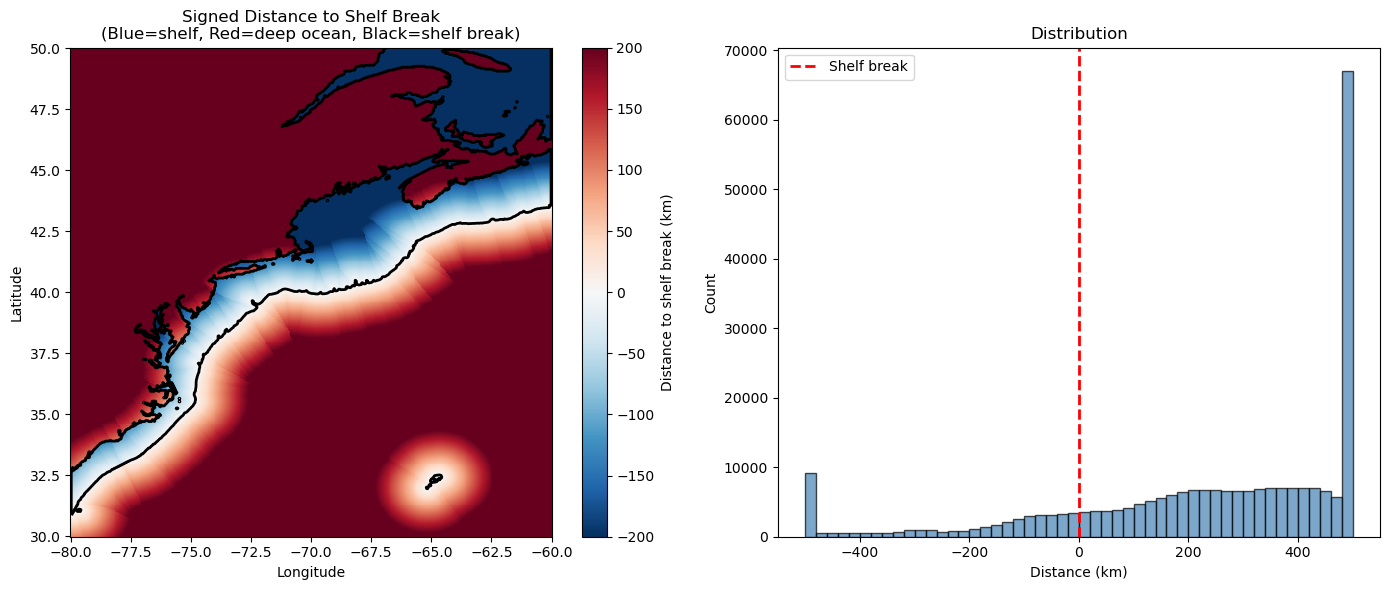

Preview saved: /home/jovyan/2026-proj-Trawling4PACE/data/harris_geomorphic/shelf_break_distance_preview.png


In [4]:
# CELL 4: Visualization (run after processing)

import matplotlib.pyplot as plt

# Get paths from GUI
output_folder = fb_output.path()
nc_file = Path(output_folder) / "shelf_break_distance.nc"

if not nc_file.exists():
    print(f"NetCDF not found: {nc_file}")
    print("Run the processing step first!")
else:
    # Load data
    ds = xr.open_dataset(nc_file)
    dist = ds['shelf_break_distance'].values
    lats = ds['latitude'].values
    lons = ds['longitude'].values
    ds.close()
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Map
    ax1 = axes[0]
    vmax = min(200, np.nanmax(np.abs(dist)))
    im = ax1.pcolormesh(lons, lats, dist, cmap='RdBu_r', vmin=-vmax, vmax=vmax, shading='auto')
    plt.colorbar(im, ax=ax1, label='Distance to shelf break (km)')
    ax1.contour(lons, lats, dist, levels=[0], colors='black', linewidths=2)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Signed Distance to Shelf Break\n(Blue=shelf, Red=deep ocean, Black=shelf break)')
    
    # Histogram
    ax2 = axes[1]
    valid = dist[~np.isnan(dist)].flatten()
    ax2.hist(valid, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Shelf break')
    ax2.set_xlabel('Distance (km)')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(Path(output_folder) / 'shelf_break_distance_preview.png', dpi=150)
    plt.show()
    
    print(f"Preview saved: {output_folder}/shelf_break_distance_preview.png")

In [ ]:
# CELL 5: Usage in Correlation Dashboard

print("""
================================================================================
COMO USAR NO CORRELATION DASHBOARD
================================================================================

O arquivo NetCDF foi salvo em: {output}/shelf_break_distance.nc

No Correlation Dashboard:
1. Clique em "Scan Folders" na aba NetCDF
2. A pasta aparecerá como uma fonte de dados
3. Selecione a variável 'shelf_break_distance'
4. Adicione como qualquer outra variável

Interpretação dos valores:
  NEGATIVO = Ponto está na PLATAFORMA CONTINENTAL (shelf)
  POSITIVO = Ponto está no OCEANO PROFUNDO (slope/abyss)
  ZERO     = Ponto está exatamente na QUEBRA DA PLATAFORMA

Exemplos de análises:
  - Captura de peixe vs shelf_break_distance 
    (espécies de plataforma devem ter correlação negativa)
  - Clorofila vs shelf_break_distance 
    (produtividade geralmente maior perto da plataforma)
  - Temperatura de fundo vs shelf_break_distance

================================================================================
""".format(output=fb_output.path()))